# A4 — PCA analysis (cleaned & validated)
This notebook is a cleaned and validated version of `A4_PCA_final.ipynb`.  
It contains a robust pipeline to load your whitespace-separated `93cars.dat.csv` file, coerce numeric columns,
compute correlations, run PCA, and visualize explained variance. Run cells top-to-bottom in a fresh kernel.


In [3]:
# 1) Load dataset robustly (regex separator); treat '*' as NA
import pandas as pd
import numpy as np

path = "93cars.dat.csv"
df = pd.read_csv(path, sep=r'\s+', engine='python', na_values=['*'])
df.columns = [c.strip() for c in df.columns]
print("raw shape:", df.shape)
print("columns (first 30):", df.columns.tolist()[:30])

raw shape: (93, 26)
columns (first 30): ['Manufacturer', 'Model', 'Type', 'MinPrice', 'MidPrice', 'MaxPrice', 'CityMpg', 'HighwayMpg', 'AirBags', 'DriveTrainType', 'Cylinders', 'Engine', 'Horsepower', 'RPM', 'EngineRev', 'ManTrans', 'Tank', 'Passenger', 'Length', 'Wheelbase', 'Width', 'UTurn', 'RearSeatRoom', 'LuggageCapacity', 'Weight', 'Domestic']


In [4]:
# 2) Coerce numeric conversions safely and create numeric-only dataframe
for col in list(df.columns):
    df[col + "_num"] = pd.to_numeric(df[col], errors='coerce')

numeric_cols = [c for c in df.columns if c.endswith("_num")]
numeric_df = df[numeric_cols].copy()

# Drop columns that are all-NaN or zero variance
numeric_df = numeric_df.dropna(axis=1, how='all')
numeric_df = numeric_df.loc[:, numeric_df.var() > 0]

print("numeric shape:", numeric_df.shape)
print("numeric columns:", numeric_df.columns.tolist())

numeric shape: (93, 24)
numeric columns: ['Model_num', 'MinPrice_num', 'MidPrice_num', 'MaxPrice_num', 'CityMpg_num', 'HighwayMpg_num', 'AirBags_num', 'DriveTrainType_num', 'Cylinders_num', 'Engine_num', 'Horsepower_num', 'RPM_num', 'EngineRev_num', 'ManTrans_num', 'Tank_num', 'Passenger_num', 'Length_num', 'Wheelbase_num', 'Width_num', 'UTurn_num', 'RearSeatRoom_num', 'LuggageCapacity_num', 'Weight_num', 'Domestic_num']


In [5]:
# 3) Compute Pearson correlation on numeric-only data
lin_corr = numeric_df.corr()
print("Correlation matrix shape:", lin_corr.shape)
# show top absolute correlations (off-diagonal)
import numpy as np
corr_vals = lin_corr.abs().where(~np.eye(lin_corr.shape[0], dtype=bool))
top_pairs = corr_vals.unstack().sort_values(ascending=False).dropna().drop_duplicates().head(10)
top_pairs.to_frame(name='abs_corr')

Correlation matrix shape: (24, 24)


,,abs_corr
MidPrice_num,MaxPrice_num,0.981580
MinPrice_num,MidPrice_num,0.970601
HighwayMpg_num,CityMpg_num,0.943936
MaxPrice_num,MinPrice_num,0.906756
Tank_num,Weight_num,0.894018
Cylinders_num,Engine_num,0.890732
Width_num,Weight_num,0.874961
Wheelbase_num,Weight_num,0.871895
Width_num,Engine_num,0.867110
Weight_num,Engine_num,0.845075


In [6]:
# 4) PCA: standardize, fit, and report explained variance and top loadings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = numeric_df.fillna(numeric_df.mean())
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

pca = PCA()
pca.fit(Xs)
explained = pca.explained_variance_ratio_
cum_explained = explained.cumsum()

print(f"PC1+PC2 explained variance: {explained[0] + explained[1]:.4f} ({100*(explained[0]+explained[1]):.2f}%)")
components_for_90 = int(np.searchsorted(cum_explained, 0.90) + 1)
print('Components to reach >=90% variance:', components_for_90)

# Top loadings for PC1
import pandas as pd
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])])
top_loadings_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(10)
top_loadings_pc1.to_frame(name='abs_loading_pc1')

PC1+PC2 explained variance: 0.6492 (64.92%)
Components to reach >=90% variance: 9


,abs_loading_pc1
Weight_num,0.269722
Engine_num,0.260784
Width_num,0.255532
Cylinders_num,0.245857
Tank_num,0.245544
Wheelbase_num,0.245117
Length_num,0.244638
CityMpg_num,0.239552
UTurn_num,0.233168
EngineRev_num,0.230058


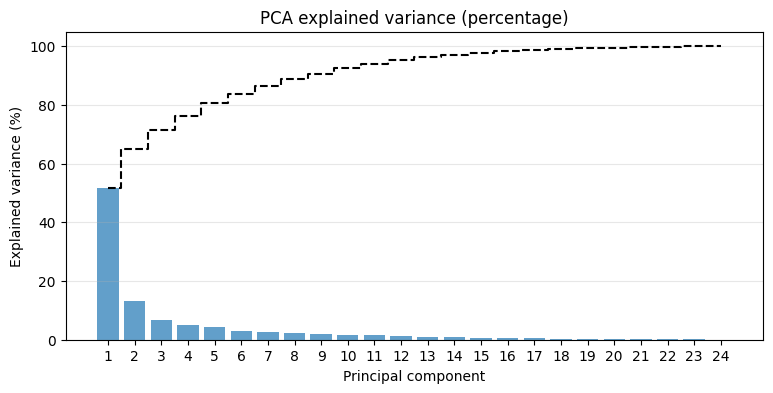

In [7]:
# 5) Plot explained variance (Matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
plt.bar(range(1, len(explained)+1), explained*100, alpha=0.7, align='center')
plt.step(range(1, len(cum_explained)+1), cum_explained*100, where='mid', linestyle='--', color='black')
plt.xlabel('Principal component')
plt.ylabel('Explained variance (%)')
plt.title('PCA explained variance (percentage)')
plt.xticks(range(1, len(explained)+1))
plt.grid(axis='y', alpha=0.3)
plt.show()

In [8]:
# 6) Suggest discriminative variables between 'Large' and 'Van' (Cohen's d)
if 'Type' in df.columns:
    groups = df[df['Type'].isin(['Large','Van'])]
    if groups.shape[0] == 0:
        print("No rows with Type in ['Large','Van']")
    else:
        large = groups[groups['Type']=='Large']
        van = groups[groups['Type']=='Van']
        def cohens_d(a,b):
            a = pd.to_numeric(a, errors='coerce').dropna()
            b = pd.to_numeric(b, errors='coerce').dropna()
            na, nb = len(a), len(b)
            if na < 2 or nb < 2:
                return np.nan
            sa, sb = a.std(ddof=1), b.std(ddof=1)
            pooled = np.sqrt(((na-1)*sa*sa + (nb-1)*sb*sb) / (na+nb-2))
            return (a.mean() - b.mean())/pooled if pooled>0 else 0.0
        effects = {}
        for col in numeric_df.columns:
            a = large.get(col)
            b = van.get(col)
            if a is not None and b is not None:
                effects[col] = abs(cohens_d(a, b))
        ef = pd.Series(effects).sort_values(ascending=False)
        print("Top discriminative numeric features (Cohen's d):")
        display(ef.head(10))
else:
    print("'Type' column not present in original dataframe.")

Top discriminative numeric features (Cohen's d):


,0
Passenger_num,5.000000
HighwayMpg_num,3.569561
AirBags_num,2.050277
Length_num,1.950339
DriveTrainType_num,1.786031
EngineRev_num,1.485747
Horsepower_num,1.447875
Engine_num,1.388344
MinPrice_num,1.386552
Domestic_num,1.264911


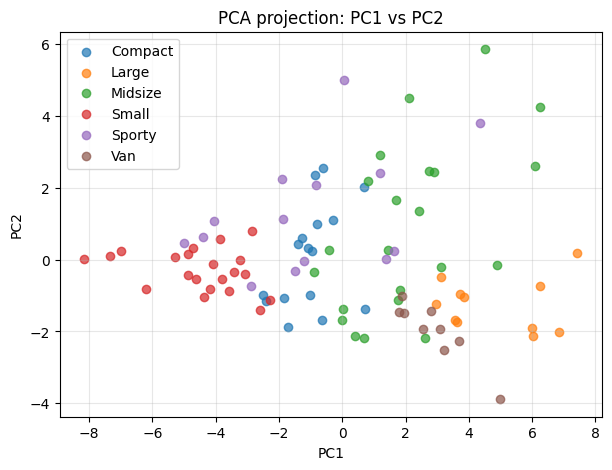

In [9]:
# 7) PCA projection scatter (PC1 vs PC2)
import matplotlib.pyplot as plt
Xp = pca.transform(Xs)  # rows x components
pc1 = Xp[:,0]
pc2 = Xp[:,1]

plt.figure(figsize=(7,5))
if 'Type' in df.columns:
    types = df['Type'].astype(str).fillna('NA')
    unique = sorted(types.unique())
    cmap = plt.get_cmap('tab10')
    color_map = {u: cmap(i % 10) for i,u in enumerate(unique)}
    for u in unique:
        mask = (types == u)
        plt.scatter(pc1[mask], pc2[mask], label=u, alpha=0.7)
    plt.legend()
else:
    plt.scatter(pc1, pc2, alpha=0.7)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection: PC1 vs PC2')
plt.grid(True, alpha=0.3)
plt.show()
